## Apartado 3. Visualización espacial con Datashader

El Ayuntamiento de Barcelona publica un conjunto de datos sobre los árboles de las calles de la ciudad (arbolado viario) en su catálogo de datos abiertos. Son casi 150.000 árboles.

Queremos obtener una imagen con Datashader que muestre la ubicación de todos los árboles del municipio. Para ello, debéis utilizar las columnas x_etrs89 y y_etrs89, que ya están en un sistema de coordenadas proyectado. Usa una paleta de colores que permita identificar claramente las zonas con mayor densidad de árboles.

In [1]:
!pip install datashader

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 45.7 MB/s eta 0:00:00


In [2]:
!pip install dash

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 60.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 15.7 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [3]:
!pip install dask[dataframe]

INFO: pip is looking at multiple versions of dask-expr to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.2/243.2 kB 8.4 MB/s eta 0:00:00


In [4]:
import pandas as pd
import datashader as ds
import datashader.transfer_functions as tf
import matplotlib.pyplot as plt

df = pd.read_csv('https://opendata-ajuntament.barcelona.cat/data/dataset/27b3f8a7-e536-4eea-b025-ce094817b2bd/resource/23124fd5-521f-40f8-85b8-efb1e71c2ec8/download', sep=',')
df.head()

/usr/local/lib/python3.11/dist-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/usr/local/lib/python3.11/dist-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 272, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment variable NUMBA_CUDA_DRIVER
with the file path of the CUDA driver shared library.
:


Not patching Numba
  warnings.warn(msg, UserWarning)
/usr/local/lib/python3.11/dist-packages/cudf/utils/gpu_utils.py:62: UserWarning: Failed to dlopen libcuda.so.1
  warnings.warn(str(e))


,codi,x_etrs89,y_etrs89,latitud,longitud,tipus_element,espai_verd,adreca,cat_especie_id,cat_nom_cientific,...,categoria_arbrat,data_plantacio,tipus_aigua,tipus_reg,geom,catalogacio,codi_barri,nom_barri,codi_districte,nom_districte
0,0000025AR,430270.562,4587637.998,41.437287,2.165353,ARBRE VIARI,"Central de Nou Barris, Parc","Pg Fabra i Puig, 450",2336,Fraxinus angustifolia 'Raywood',...,PRIMERA,2022-02-15,NaN,GOTEIG AVARIAT,POINT (430270.561661092 4587637.99844993),NaN,48.0,LA GUINEUETA,8.0,NOU BARRIS
1,0000028AR,430278.453,4587643.703,41.437339,2.165447,ARBRE VIARI,"Central de Nou Barris, Parc","Pg Fabra i Puig, 450",2336,Fraxinus angustifolia 'Raywood',...,PRIMERA,2022-02-15,NaN,GOTEIG AVARIAT,POINT (430278.452565526 4587643.70285161),NaN,48.0,LA GUINEUETA,8.0,NOU BARRIS
2,0000386AR,430035.239,4587693.836,41.437769,2.162530,ARBRE VIARI,"Central de Nou Barris, Parc","C\ Doctor Letamendi, 90",126,Platanus × acerifolia,...,SEGONA,NaN,NaN,SENSE INFORMAR,POINT (430035.238676006 4587693.83631125),NaN,43.0,HORTA,7.0,HORTA - GUINARDÓ
3,0000387AR,430032.831,4587696.005,41.437788,2.162501,ARBRE VIARI,"Central de Nou Barris, Parc","C\ Doctor Letamendi, 90",126,Platanus × acerifolia,...,SEGONA,NaN,NaN,SENSE INFORMAR,POINT (430032.831137134 4587696.00500337),NaN,43.0,HORTA,7.0,HORTA - GUINARDÓ
4,0000388AR,430030.367,4587698.393,41.437810,2.162471,ARBRE VIARI,"Central de Nou Barris, Parc","C\ Doctor Letamendi, 90",126,Platanus × acerifolia,...,SEGONA,NaN,NaN,SENSE INFORMAR,POINT (430030.366746935 4587698.39336605),NaN,43.0,HORTA,7.0,HORTA - GUINARDÓ


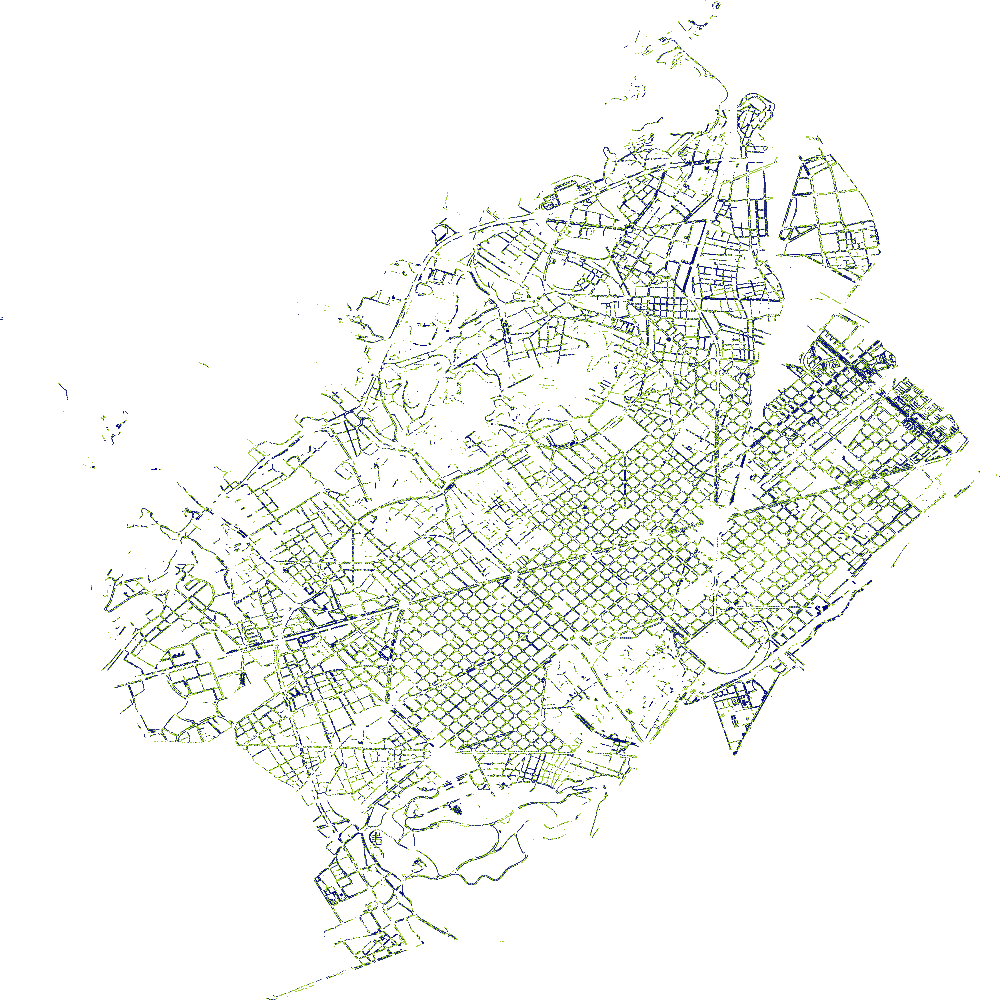

In [17]:
cvs = ds.Canvas(
    x_range=(df['x_etrs89'].min(), df['x_etrs89'].max()),
    y_range=(df['y_etrs89'].min(), df['y_etrs89'].max()),
    plot_width=1000,
    plot_height=1000
)
agg = cvs.points(df, 'x_etrs89', 'y_etrs89')
img = tf.shade(agg, cmap=['yellowgreen', 'darkblue'], how='eq_hist')
img